# Modelling and Evaluation Notebook

## Objectives
* Answer Business Requirement 2:
    * The client is interested to know if a cherry leaf has powdery mildrew or not.

## Inputs
    * inputs/cherry_leaves/cherry-leaves/train
    * inputs/cherry_leaves/cherry-leaves/test
    * inputs/cherry_leaves/cherry-leaves/validation
    * Image shape embeddings

## Outputs 
    * Images distribution plot in train, validation and test set
    * Image augmentation
    * Class indices to change prediction inference in labels
    * Machine learning model creation and training
    * Save model
    * Learning curve plot for model performance
    * Model evaluation on pickle file
    * Prediction on the random image file
    
## Additional Comments | Insights | Conclusions

# Set Data Directory

## Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [ ]:
current_dir = os.getcwd()
current_dir

In [ ]:
os.chdir('/workspace/P5-Mildew-Detection-in-Cherry-Leaves')
print("You set a new current directory")

In [ ]:
work_dir = os.getcwd()
work_dir

## Set Input Directories
Set train, validation and test paths

In [ ]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'

## Set Output Directory

In [ ]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

### Set labels

In [ ]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

## Set image shape

In [ ]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

---

## Number of images in train, test and validation data

In [ ]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image data augmentation

---

### ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [ ]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Augment training image dataset

In [ ]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

### Augment validation image dataset

In [ ]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

### Augment test image dataset

In [ ]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

## Plot augmented training image

In [ ]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

In [ ]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [ ]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [ ]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

---

## Model creation

### ML Model

* #### Import model packages

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* #### Model

In [ ]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

* #### Model Summary

In [ ]:
create_tf_model().summary()

* #### Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

### Fit model for model training

In [ ]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

### Save Model

In [ ]:
model.save('outputs/v1/cherry_leaves_model.h5')

---

## Model Performance

### Model learning curve

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation
Load saved model

In [32]:
from keras.models import load_model
model = load_model('outputs/v1/cherry_leaves_model.h5')

#### Evaluate model accuracy on the test set

In [33]:
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

43/43 [==============================] - 19s 438ms/step - loss: 5.1435e-04 - accuracy: 1.0000
Test Accuracy: 100.00%


### Save evaluation pickle

In [34]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data
Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


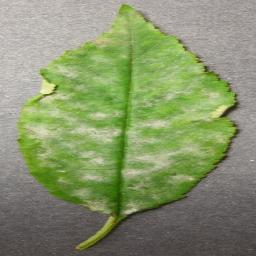

In [101]:
from tensorflow.keras.preprocessing import image
import random

label = random.choice(labels) 

pointer = random.randint(0, len(os.listdir(test_path + '/' + label)) - 1)

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [102]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [103]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1.0
powdery_mildew


---

## Push files to Repo
### Push generated/new files from this session to GitHub repo
* .gitignore

In [104]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git status

In [105]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   README.md
	modified:   jupyter_notebooks/ModellingandEvaluating.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	app.py
	app_pages/
	outputs/v1/cherry_leaves_model.h5
	outputs/v1/class_indices.pkl
	outputs/v1/evaluation.pkl
	outputs/v1/labels_distribution.png
	outputs/v1/model_training_acc.png
	outputs/v1/model_training_losses.png
	src/

no changes added to commit (use "git add" and/or "git commit -a")


* Git add 

In [106]:
!git add .

* Git commit

In [107]:
!git commit -am " Add new plots"

[main 04fa1a6]  Add new plots
 18 files changed, 525 insertions(+), 169 deletions(-)
 create mode 100644 app.py
 create mode 100644 app_pages/multipage.py
 create mode 100644 app_pages/page_cherryleaves_detector.py
 create mode 100644 app_pages/page_cherryleaves_visualizer.py
 create mode 100644 app_pages/page_ml_performance.py
 create mode 100644 app_pages/page_project_hypothesis.py
 create mode 100644 app_pages/page_summary.py
 create mode 100644 outputs/v1/cherry_leaves_model.h5
 create mode 100644 outputs/v1/class_indices.pkl
 create mode 100644 outputs/v1/evaluation.pkl
 create mode 100644 outputs/v1/labels_distribution.png
 create mode 100644 outputs/v1/model_training_acc.png
 create mode 100644 outputs/v1/model_training_losses.png
 create mode 100644 src/data_management.py
 create mode 100644 src/machine_learning/evaluate_clf.py
 create mode 100644 src/machine_learning/predictive_analysis.py


* Git Push

In [108]:
!git push

Enumerating objects: 32, done.
Counting objects: 100% (32/32), done.
Delta compression using up to 32 threads
Compressing objects: 100% (23/23), done.
Writing objects: 100% (26/26), 64.85 MiB | 11.69 MiB/s, done.
Total 26 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/cherry_leaves_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/Katherine-Holland/P5-Mildew-Detection-in-Cherry-Leaves.git
   dd754a0..04fa1a6  main -> main


---